# Generative Adversarial Network
made in Colab

In [104]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

## Load the data (MNIST)

In [105]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train / 255.0, x_test /255.0

In [106]:
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [107]:
latent_dim = 100

## Building models

### Generator model

In [108]:
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(2048, activation=LeakyReLU(alpha=0.1))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(4096, activation=LeakyReLU(alpha=0.1))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(D, activation='tanh')(x)

    model = Model(i, x)
    return model

### Discriminator model

In [109]:
def build_discriminator(img_size):
    i = Input(img_size,)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(128, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(i, x)
    return model

### Compiling and preparing models for training

In [110]:
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

generator = build_generator(latent_dim)
sample = Input(shape=(latent_dim,))
sample_img = generator(sample)

discriminator.trainable = False

fake_pred = discriminator(sample_img)
combined_model = Model(sample, fake_pred)

combined_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5)
)

## Train the GAN

In [111]:
# Config
batch_size = 32
epochs = 35000
sample_period = 200

# Batch labels
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Losses storage
d_losses = []
g_losses = []

# Generated images storage
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [112]:
# Generating random samples and saving them to a file
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    # Rescaling 0-1
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig('gan_images/%d.png' % epoch)
    plt.close()

### Training loop

In [113]:
for epoch in range(epochs):

    ##### Discriminator #####

    # Random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]

    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)

    # Train discriminator
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    ##### Generator #####

    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)

    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 100 == 0:
        print(f'epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}')

    if epoch % sample_period == 0:
        sample_images(epoch)


epoch: 1/35000, d_loss: 0.64, d_acc: 0.50, g_loss: 0.60
epoch: 101/35000, d_loss: 0.31, d_acc: 0.94, g_loss: 2.22
epoch: 201/35000, d_loss: 0.28, d_acc: 0.94, g_loss: 2.30
epoch: 301/35000, d_loss: 0.25, d_acc: 0.95, g_loss: 3.27
epoch: 401/35000, d_loss: 0.27, d_acc: 0.92, g_loss: 3.87
epoch: 501/35000, d_loss: 0.17, d_acc: 0.97, g_loss: 3.49
epoch: 601/35000, d_loss: 0.13, d_acc: 0.98, g_loss: 4.88
epoch: 701/35000, d_loss: 0.18, d_acc: 0.95, g_loss: 5.56
epoch: 801/35000, d_loss: 0.13, d_acc: 0.98, g_loss: 10.12
epoch: 901/35000, d_loss: 0.13, d_acc: 1.00, g_loss: 6.25
epoch: 1001/35000, d_loss: 0.08, d_acc: 0.98, g_loss: 5.50
epoch: 1101/35000, d_loss: 0.08, d_acc: 1.00, g_loss: 5.79
epoch: 1201/35000, d_loss: 0.16, d_acc: 0.91, g_loss: 7.75
epoch: 1301/35000, d_loss: 0.29, d_acc: 0.88, g_loss: 7.04
epoch: 1401/35000, d_loss: 0.10, d_acc: 1.00, g_loss: 10.01
epoch: 1501/35000, d_loss: 0.18, d_acc: 0.95, g_loss: 6.98
epoch: 1601/35000, d_loss: 0.31, d_acc: 0.91, g_loss: 5.14
epoch: 

## Analysing results

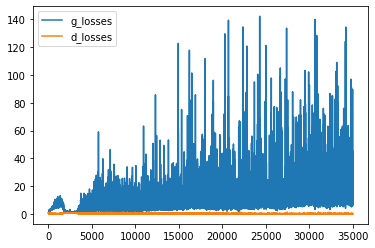

In [114]:
# both losses should never stay in low values for too long, because both models
# are training against each other

plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

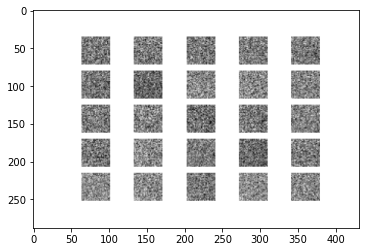

In [115]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

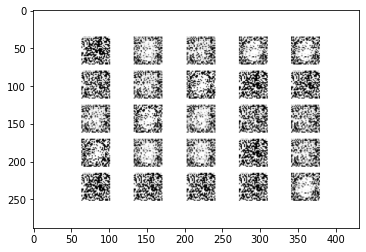

In [116]:
a = imread('gan_images/1000.png')
plt.imshow(a)

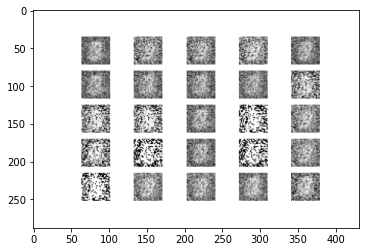

In [117]:
a = imread('gan_images/2000.png')
plt.imshow(a)

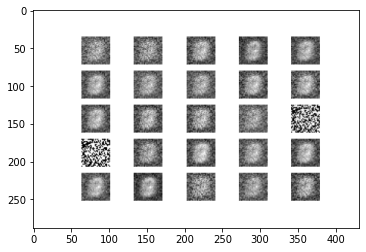

In [118]:
a = imread('gan_images/5000.png')
plt.imshow(a)

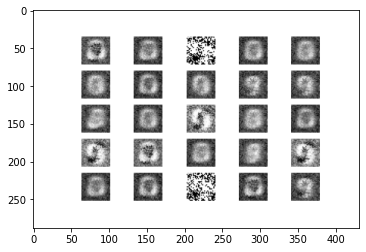

In [119]:
a = imread('gan_images/10000.png')
plt.imshow(a)

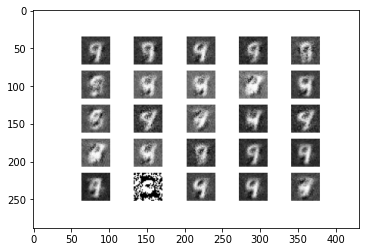

In [120]:
a = imread('gan_images/20000.png')
plt.imshow(a)

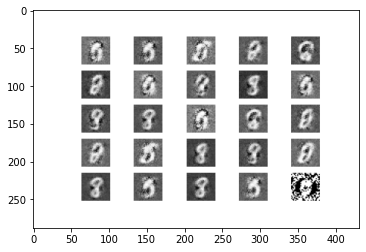

In [121]:
a = imread('gan_images/34800.png')
plt.imshow(a)